In [1]:
import networkx as nx
import numpy as np
import random
import json
import logging

from magi_dataclasses import * 
from tqdm.auto import tqdm, trange
from operator import itemgetter
from networkx.algorithms.community import *
from matplotlib import pyplot as plt
from contextlib import contextmanager
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases

from itertools import chain
from typing import Tuple, List

@contextmanager
def set_logger(level=logging.ERROR):
    levels = {}
    for k, _ in logging.root.manager.loggerDict.items():
        if not ('gensim' in k or 'magi_dataclasses' in k):
            continue
        levels[k] = logging.getLogger(k).level
        logging.getLogger(k).setLevel(level)
    try:
        yield
    finally:
        for k, _level in levels.items():
            logging.getLogger(k).setLevel(_level)

In [3]:
github_dataset = GitHubDataset(
    empty = False,
    file_path = './ghv9_tokenized.json',
    load_nlp = True,
    load_graph = True,
)
print(github_dataset.statistics.to_latex())

magi_dataclasses - INFO - Loaded 5000 repos to D:\OneDrive - Umich\UMSI\2022 Fall\SI671\MAGI_dm\src\ghv9-3.json
magi_dataclasses - INFO - Graph nodes attribute betweenness_centrality calculated using <function betweenness_centrality at 0x00000203559F0840>
magi_dataclasses - INFO - Graph nodes attribute out_degree calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda> at 0x000002032C890D90>
magi_dataclasses - INFO - Graph nodes attribute in_degree calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda> at 0x00000203324A9BF8>
magi_dataclasses - INFO - Graph nodes attribute page_rank_0.90 calculated using functools.partial(<function pagerank at 0x0000020355C44730>, alpha=0.9)
magi_dataclasses - INFO - Graph nodes attribute page_rank_0.50 calculated using functools.partial(<function pagerank at 0x0000020355C44730>, alpha=0.5)
magi_dataclasses - INFO - Graph nodes attribute hits calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda>

\begin{tabular}{lr}
\toprule
{} &        Value \\
Statistics                  &              \\
\midrule
Max Length of README Corpus &   27703.0000 \\
Min Length of README Corpus &       1.0000 \\
Avg Length of README Corpus &     380.3836 \\
Max Length of HN Corpus     &    1282.0000 \\
Min Length of HN Corpus     &       1.0000 \\
Avg Length of HN Corpus     &      28.3690 \\
\%Data with README file      &       0.9388 \\
\%Data with HN Comments      &       0.5668 \\
Max Stars                   &  215570.0000 \\
Min Stars                   &     755.0000 \\
Avg Stars                   &    8978.0046 \\
\bottomrule
\end{tabular}



In [2]:
github_dataset = GitHubDataset(
    empty = False,
    file_path = './ghv9-2.json',
    load_nlp = True,
    load_graph = True,
)

github_dataset._remove_code_chunk()

for index in trange(len(github_dataset)):
    github_dataset.get_corpus(index, n_process=1)
    
github_dataset.dump('ghv9_tokenized.json')

magi_dataclasses - INFO - Loaded 5000 repos to D:\OneDrive - Umich\UMSI\2022 Fall\SI671\MAGI_dm\src\ghv9-2.json
magi_dataclasses - INFO - Graph nodes attribute betweenness_centrality calculated using <function betweenness_centrality at 0x000001EC1CEC5E18>
magi_dataclasses - INFO - Graph nodes attribute out_degree calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda> at 0x000001EC7479E598>
magi_dataclasses - INFO - Graph nodes attribute in_degree calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda> at 0x000001EC74B0E6A8>
magi_dataclasses - INFO - Graph nodes attribute page_rank_0.90 calculated using functools.partial(<function pagerank at 0x000001EC1CF77C80>, alpha=0.9)
magi_dataclasses - INFO - Graph nodes attribute page_rank_0.50 calculated using functools.partial(<function pagerank at 0x000001EC1CF77C80>, alpha=0.5)
magi_dataclasses - INFO - Graph nodes attribute hits calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda>

In [3]:
def read_communities(G: nx.DiGraph):
    communities = []
    for index, node in G.nodes(data = True):
        while len(communities) <= node['community']:
            communities.append([])
        communities[node['community']].append(index)
    return [frozenset(x) for x in communities]

# use pure lda to build communities
def build_lda_communities(
    github_dataset: GitHubDataset, 
    n_communities: int = 5, 
    verbose: bool = False, 
    benchmark: bool = True, 
    alpha: str = 'symmetric',
    eta: str = 'symmetric',
    kappa: float = 0.5, 
    n_gram = 2
) -> Tuple[nx.Graph, List[frozenset]]:
    
    with set_logger(logging.INFO if verbose else logging.ERROR):
        # now remove the indexing repos with pattern filtering
        filtered_repo_names = github_dataset.filter_repos('./patterns.txt')
        filtered_repos = [index for index, node in github_dataset.G.nodes(data=True) if node['name'] in filtered_repo_names]
        github_dataset.G.remove_nodes_from(filtered_repos)
        
        total_corpus = {
            index: github_dataset[node['name']].tokenized_corpus \
                for index, node in github_dataset.G.nodes(data = True) if len(github_dataset[node['name']].tokenized_corpus) > 0
        }
        
        data_lemmatized = list(total_corpus.values())
        for _ in range(n_gram - 1):
            n_gram = Phrases(data_lemmatized, min_count=5)
            data_lemmatized = [n_gram[doc] for doc in data_lemmatized]
        dictionary = corpora.Dictionary(data_lemmatized)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]
        
        model = LdaMulticore(
            corpus = doc_term_matrix,
            num_topics = n_communities,
            id2word = dictionary,
            passes = 20,
            chunksize = 2000,
            random_state = 42,
            decay = kappa,
            alpha = alpha,
            eta = eta,
            workers = 10
        )
        raw_topics = model.show_topics(num_topics = n_communities, num_words = 10)
        topic_pattern = re.compile('\*"([\S]+)"')
        topics = {}
        for (topic_index, topic_text) in raw_topics:
            topic_words = ', '.join(topic_pattern.findall(topic_text))
            topics[topic_index] = topic_words

        for node_index, doc in total_corpus.items():   
            topic_index = model.get_document_topics(dictionary.doc2bow(doc))[0][0]
            github_dataset.G.nodes[node_index]['community'] = topic_index
            github_dataset.G.nodes[node_index]['topics'] = topics[topic_index]


        communities = [
            [] for _ in range(len(topics))
        ]
        for index, node in github_dataset.G.nodes(data = True):
            if node['community'] >= 0:
                communities[node['community']].append(index)
            
        communities = [frozenset(x) for x in communities]
        if not benchmark:
            return communities
        
        # begin benchmarking
        coherence_model_lda = CoherenceModel(
            model = model, 
            texts = data_lemmatized, 
            dictionary = dictionary, 
            coherence = 'c_v'
        )
        coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

In [ ]:
coherence_lda_scores = {}
for num_topics in trange(5, 20):
    for alpha in ['symmetric', 'asymmetric']:
        for kappa in np.arange(0.5, 1, 0.1):
            github_dataset = GitHubDataset(
                empty = False,
                file_path = './ghv9_tokenized.json',
                load_nlp = True,
                load_graph = True
            )
            coherence_lda_scores[f'nt={num_topics},alpha={alpha},kappa={kappa}'] = (
                build_lda_communities(
                    github_dataset = github_dataset, 
                    n_communities = num_topics, 
                    alpha = alpha,
                    eta = 'symmetric',
                    kappa = kappa,
                    verbose = False,
                    benchmark = True
                )
            )
with open('unigram_run.json', 'w') as f:
    json.dump(coherence_lda_scores, f)

In [4]:
coherence_lda_scores_bigram = []
for n_communities in trange(5, 20):
    with set_logger(logging.ERROR): 
        github_dataset = GitHubDataset(
            empty = False,
            file_path = './ghv9_tokenized.json',
            load_nlp = True,
            load_graph = True
        )
    coherence_lda_scores_bigram.append(
        build_lda_communities(
            github_dataset = github_dataset, 
            n_communities = n_communities, 
            alpha = 'asymmetric',
            eta = 'symmetric',
            kappa = 0.5,
            n_gram = 2,
            verbose = False,
            benchmark = True,
        )
    )
with open('bigram_run.json', 'w') as f:
    json.dump(coherence_lda_scores_bigram, f)

  7%|▋         | 1/15 [01:14<17:23, 74.53s/it]

In [ ]:
coherence_lda_scores_trigram = []
for n_communities in trange(5, 20):
    with set_logger(logging.ERROR): 
        github_dataset = GitHubDataset(
            empty = False,
            file_path = './ghv9_tokenized.json',
            load_nlp = True,
            load_graph = True
        )
    coherence_lda_scores_trigram.append(
        build_lda_communities(
            github_dataset = github_dataset, 
            n_communities = n_communities, 
            alpha = 'asymmetric',
            eta = 'symmetric',
            kappa = 0.5,
            n_gram = 3,
            verbose = False,
            benchmark = True,
        )
    )
with open('trigram_run.json', 'w') as f:
    json.dump(coherence_lda_scores_trigram, f)

In [ ]:
# use greedy modularity detection to build communities
# build communities with the indexing repos
def build_greedy_modularity_communities(
    github_dataset: GitHubDataset,
    verbose: bool = False
) -> Tuple[nx.Graph, List[frozenset]]:
    gm_c = greedy_modularity_communities(github_dataset.G)
        
    # reverse lookup dict
    communities = {}
    for cid, community in enumerate(gm_c):
        for repo in community:
            communities[repo] = cid
    nx.set_node_attributes(github_dataset.G, communities, 'community')

    # now remove the indexing repos with pattern filtering
    
    filtered_repo_names = github_dataset.filter_repos('patterns.txt')
    filtered_repos = [index for index, node in github_dataset.G.nodes(data=True) if node['name'] in filtered_repo_names]
    github_dataset.G.remove_nodes_from(filtered_repos)
    if verbose:
        print(f'{len(filtered_repos)} nodes removed from graph')

    gm_c_removed = [[] for _ in range(len(gm_c))]
    for index, node in github_dataset.G.nodes(data = True):
        gm_c_removed[node['community']].append(index)

    with set_logger(logging.INFO if verbose else logging.ERROR):    
        total_corpus = [[github_dataset[github_dataset.G.nodes[repo]['name']].tokenized_corpus for repo in repo_set] for repo_set in tqdm(gm_c_removed)]
        dictionary = corpora.Dictionary(chain(*total_corpus))
        repo_set_topics = []
        for repo_set, repo_docs in zip(communities, total_corpus):
            if type(repo_set) is int:
                continue
            doc_term_matrix = [dictionary.doc2bow(doc) for doc in repo_docs]
            lda = LdaModel(
                doc_term_matrix, 
                num_topics = 1,
                id2word = dictionary,
                passes = 30,
                chunksize = 2000,
                random_state = 42
            )
            repo_set_topics.append(
                (repo_set, lda)
            )
    topic_pattern = re.compile('\*"([\S]+)"')
    for repo_set, lda in repo_set_topics:
        topic_words = topic_pattern.findall(lda.print_topics(num_words = 10)[0][1])
        for node in repo_set:
            github_dataset.G.nodes[node]['topics'] = ', '.join(topic_words)
    
    return [frozenset(x) for x in gm_c_removed]

github_dataset = GitHubDataset(
    empty = False,
    file_path = './ghv9_tokenized.json',
    load_nlp = True,
    load_graph = True
)
communities = build_greedy_modularity_communities(github_dataset)

## Visualization of Analysis Results

In [6]:
import altair as alt
github_dataset = GitHubDataset(
    empty = False,
    file_path = './ghv9_tokenized.json',
    load_nlp = True,
    load_graph = True
)

results = []
for language in github_dataset.LANG_LIST:
    nodes = [node for _, node in github_dataset.G.nodes(data = True) if node['language'] == language]
    nodes.sort(reverse = True, key = lambda x: x['page_rank_0.90'])
    results += nodes[0:5]
page_rank_df = pd.DataFrame(results)
page_rank_df = page_rank_df.rename(columns={'page_rank_0.90': 'page_rank'})
page_rank_df.head()

results = []
for language in github_dataset.LANG_LIST:
    nodes = [node for _, node in github_dataset.G.nodes(data = True) if node['language'] == language]
    nodes.sort(reverse = True, key = lambda x: x['out_degree'])
    results += nodes[0:5]
out_degree_df = pd.DataFrame(results)
out_degree_df.head()

alt.Chart(page_rank_df).mark_bar().encode(
    x = alt.X('page_rank:Q', title='Page Rank'),
    y = alt.Y('name:N', sort = '-x'),
    color = alt.Color('language:O', scale=alt.Scale(scheme='viridis'))
).properties(
    title = 'Page Rank Top 5 Repos for Each Language',
    width = 360 
) & alt.Chart(out_degree_df).mark_bar().encode(
    x = alt.X('out_degree:Q', title='Out Degree'),
    y = alt.Y('name:N', sort = '-x'),
    color = alt.Color('language:O', scale=alt.Scale(scheme='viridis'))
).properties(
    title = 'Out Degree Top 5 Repos for Each Language',
    width = 360   
)

magi_dataclasses - INFO - Loaded 5000 repos to /Users/enoch/OneDrive - Umich/UMSI/2022 Fall/SI671/MAGI_dm/src/ghv9-3.json
magi_dataclasses - INFO - Graph nodes attribute betweenness_centrality calculated using <function betweenness_centrality at 0x7faed8720310>
magi_dataclasses - INFO - Graph nodes attribute out_degree calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda> at 0x7fae99c4dd30>
magi_dataclasses - INFO - Graph nodes attribute in_degree calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda> at 0x7fae99c4df70>
magi_dataclasses - INFO - Graph nodes attribute page_rank_0.90 calculated using functools.partial(<function pagerank at 0x7fae98202af0>, alpha=0.9)
magi_dataclasses - INFO - Graph nodes attribute page_rank_0.50 calculated using functools.partial(<function pagerank at 0x7fae98202af0>, alpha=0.5)
magi_dataclasses - INFO - Graph nodes attribute hits calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda> at 0x7fae

alt.VConcatChart(...)

In [14]:
with set_logger(logging.ERROR): 
    github_dataset = GitHubDataset(
        empty = False,
        file_path = './ghv9_tokenized.json',
        load_nlp = True,
        load_graph = True
    )

build_lda_communities(
    github_dataset = github_dataset, 
    n_communities = 8,
    alpha = 'asymmetric',
    kappa = 0.5,
    n_gram = 1,
    verbose = False,
    benchmark = False
)

remove = [index for index, node in github_dataset.G.nodes(data = True) if node['community'] == -1]
github_dataset.G.remove_nodes_from(remove)
github_dataset.remove_by_degree(0)

c = read_communities(github_dataset.G)
for c_ in c:
    print(len(c_))
communities = set([node['topics'] for _, node in github_dataset.G.nodes(data=True)])
for topic in communities:
    print(topic)

magi_dataclasses - INFO - Graph nodes with degree < 0, total 3102 nodes are removed.


722
254
101
323
49
26
27
8
url, docs, package, server, documentation, doc, graphql, community, aws, provide
book, cloud, manager, script, china, argo, sciter, rqlite, data, storage
model, copyright, gan, provide, data, copy, adversarial, training, pytorch, train
crate, target, provide, cargo, database, documentation, application, contribution, model, create
profile, discussion, site, remote, plugin, package, phone, design, pair, programming
problem, docker, binary, server, number, search, grpc, log, linux, service
package, windows, linux, create, server, npm, app, documentation, download, request
kubernetes, package, set, documentation, provide, create, service, workflow, check, repository


In [15]:
import nx_altair as nxa
import altair as alt
from community_layout import community_layout
DEBUGGING = True
# DEBUGGING = False

alt.data_transformers.disable_max_rows()
# pos = nx.multipartite_layout(G, subset_key='community')
pos = community_layout(
    g = github_dataset.G, 
    partition = {
        index: node['community'] for index, node in github_dataset.G.nodes(data = True)
    }
) 

# search_box = alt.InputBinding(
#     debounce = 0.4
# )

# selection = alt.selection_single(
#     fields = ['name'], 
#     name = 'search',
#     bind = search_box,
#     empty = 'all'
# )

chart = nxa.draw_networkx(
    github_dataset.G, 
    pos = pos,
    node_size = 50,
    node_color = 'language:O',
    cmap = 'viridis',
    edge_color = 'gray',
    node_tooltip = ['name', 'language', 'community', 'topics']
)
edges = chart.layer[0]
quivers = chart.layer[1]
nodes = chart.layer[2]

edges = edges.encode(
    opacity = alt.value(0.4)
)

quivers = quivers.encode(
    opacity = alt.value(0.4)
)

nodes = nodes.encode(
    href = 'link:N',
    color = alt.Color('language:O'),
    # color = alt.condition(
    #     predicate = 'search["name"] == datum["name"]', 
    #     if_true = alt.Color('language:O'),
    #     if_false = alt.value('gray')
    # ),
    # opacity = alt.condition(
    #     predicate = 'search["name"] == datum["name"]', 
    #     if_true = alt.value(1.0),
    #     if_false = alt.value(0.1)
    # )
)

vis = (edges + quivers + nodes).properties(
    width = 1920 if not DEBUGGING else 960,
    height = 1080 if not DEBUGGING else 540   
).interactive()

vis.save('vis.html')
# vis

In [16]:
import datapane as dp

app = dp.App(
    dp.Plot(vis),
    dp.Text('Click on the nodes to open the repo in browser. Ctrl-click to open in new tab.'),
    dp.Text('Result shown above may change as I progress on the iterations of model.'),
)
app.upload(name='Topic Modeling GitHub Repositories')

Uploading app and associated data - *please wait...*

App successfully uploaded. View and share your app at <a href='https://cloud.datapane.com/apps/0kzPR23/topic-modeling-github-repositories/' target='_blank'>here</a>.

## Clustering

In [18]:
from umap import UMAP
from umap import plot as uplot
from sklearn.cluster import KMeans, OPTICS, DBSCAN, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from hdbscan import HDBSCAN

github_dataset = GitHubDataset(
    empty = False,
    file_path = './ghv9_tokenized.json',
    load_nlp = True,
    load_graph = True,
)

dataset = pd.DataFrame(
    [{'id': k, **v} for k, v in github_dataset.G.nodes(data = True)]
)
column_base = list(github_dataset._graph_processors_artifacts.keys())
dataset_normalized = dataset.copy()
standarized = MinMaxScaler().fit_transform(dataset[column_base])
dataset_normalized[column_base] = standarized - standarized.mean(axis = 0)
X = dataset_normalized[column_base]
dataset.head()

magi_dataclasses - INFO - Loaded 5000 repos to D:\OneDrive - Umich\UMSI\2022 Fall\SI671\MAGI_dm\src\ghv9-3.json
magi_dataclasses - INFO - Graph nodes attribute betweenness_centrality calculated using <function betweenness_centrality at 0x000001EC1CEC5E18>
magi_dataclasses - INFO - Graph nodes attribute out_degree calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda> at 0x000001EC8538C6A8>
magi_dataclasses - INFO - Graph nodes attribute in_degree calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda> at 0x000001EC7F4299D8>
magi_dataclasses - INFO - Graph nodes attribute page_rank_0.90 calculated using functools.partial(<function pagerank at 0x000001EC1CF77C80>, alpha=0.9)
magi_dataclasses - INFO - Graph nodes attribute page_rank_0.50 calculated using functools.partial(<function pagerank at 0x000001EC1CF77C80>, alpha=0.5)
magi_dataclasses - INFO - Graph nodes attribute hits calculated using <function GitHubDataset._init_artifacts.<locals>.<lambda>

,id,name,link,language,topics,community,stars,betweenness_centrality,out_degree,in_degree,page_rank_0.90,page_rank_0.50,hits
0,0,public-apis/public-apis,https://github.com/public-apis/public-apis,Python,,-1,215570,0.000000,0,0,0.000157,0.000180,0.000000
1,1,donnemartin/system-design-primer,https://github.com/donnemartin/system-design-p...,Python,,-1,202568,0.000000,0,0,0.000157,0.000180,0.000000
2,2,TheAlgorithms/Python,https://github.com/TheAlgorithms/Python,Python,,-1,148019,0.000000,0,2,0.000230,0.000227,0.000000
3,3,vinta/awesome-python,https://github.com/vinta/awesome-python,Python,,-1,146515,0.000131,152,3,0.000540,0.000410,0.008206
4,4,jackfrued/Python-100-Days,https://github.com/jackfrued/Python-100-Days,Python,,-1,127226,0.000000,0,0,0.000157,0.000180,0.000000


10
0.86630976


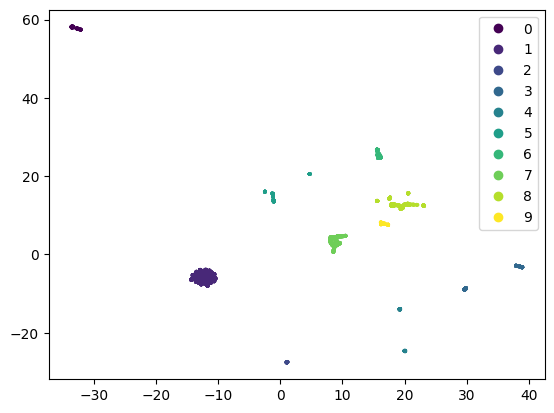

In [25]:
reducer = UMAP(
    n_neighbors=80,
    min_dist=0.0,
    n_components=2,
    random_state=42
)

visualizer = UMAP(
    n_components=2,
    random_state=42
)

umap_reduced_X = reducer.fit_transform(X)
# umap_visualize_X = visualizer.fit_transform(X)
umap_visualize_X = umap_reduced_X
labels = HDBSCAN(
    min_samples=100,
    min_cluster_size=100,
).fit_predict(umap_reduced_X)

print(len(set(labels.tolist())))

print(silhouette_score(X = umap_reduced_X, labels = labels))

scatter_umap = plt.scatter(umap_visualize_X[:, 0], umap_visualize_X[:, 1], c = labels, s = 3)
plt.legend(handles=scatter_umap.legend_elements()[0], labels=set(labels))
plt.show()
# pca = PCA(n_components=2).fit_transform(X)
# scatter_pca = plt.scatter(pca[:, 0], pca[:, 1], c = labels, s = 3)
# plt.legend(handles=scatter_pca.legend_elements()[0], labels=set(labels))
# plt.show()


In [19]:
visualizer = UMAP(
    n_components=2,
    random_state=42
)
scores = {}
umap_visualize_X = visualizer.fit_transform(X)
for min_dist in tqdm([0.0, 0.1, 0.25, 0.5, 0.8, 0.99]):
    for n_neighbors in [5, 10, 20, 40, 80]:  
        reducer = UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            random_state=42
        )
        
        umap_reduced_X = reducer.fit_transform(X)

        labels = HDBSCAN(
            min_samples=20,
            min_cluster_size=100,
        ).fit_predict(umap_reduced_X)

        scores[f'min_dist={min_dist},n_neighbors={n_neighbors}'] = tuple((silhouette_score(X = umap_reduced_X, labels = labels), len(set(labels.tolist()))))
        
data = []
for k, v in scores.items():
    keys = [x.split('=') for x in k.split(',')]
    data.append(
        {
            **{param: float(value) for [param, value] in keys},
            'silhouette_score': float(v[0]),
            'cluster_num': int(v[1])
        }
    )
clustering_data_df = pd.DataFrame(
    data = data
)
clustering_data_df.n_neighbors = clustering_data_df.n_neighbors.astype('int')
clustering_data_df.head()

100%|██████████| 6/6 [12:52<00:00, 128.72s/it]


In [ ]:
import altair as alt
alt.Chart(clustering_data_df).mark_line().encode(
    x = alt.X('min_dist:Q', title = 'Min Distance'),
    y = alt.Y('silhouette_score:Q', scale=alt.Scale(), title = 'Silhouette Score'),
    color = alt.Color('n_neighbors:O')
).properties(
    title = 'Effect of Changing Parameters of UMAP on Downstream Clustering Task'
)

In [20]:
visualizer = UMAP(
    n_components=2,
    random_state=42
)
reducer = UMAP(
    n_neighbors=80,
    min_dist=0.0,
    n_components=2,
    random_state=42
)
        
umap_reduced_X = reducer.fit_transform(X)
scores = {}
umap_visualize_X = visualizer.fit_transform(X)
for min_samples in tqdm([1, 10, 20, 50, 100, 200]):
    for min_cluster_size in [50, 100, 200, 400]: 
        labels = HDBSCAN(
            min_samples=min_samples,
            min_cluster_size=min_cluster_size,
        ).fit_predict(umap_reduced_X)

        scores[f'min_cluster_size={min_cluster_size},min_samples={min_samples}'] = tuple((silhouette_score(X = umap_reduced_X, labels = labels), len(set(labels.tolist()))))
        
data = []
for k, v in scores.items():
    keys = [x.split('=') for x in k.split(',')]
    data.append(
        {
            **{param: float(value) for [param, value] in keys},
            'silhouette_score': float(v[0]),
            'cluster_num': int(v[1])
        }
    )
clustering_data_df = pd.DataFrame(
    data = data
)
clustering_data_df.min_samples = clustering_data_df.min_samples.astype('int')
clustering_data_df.min_cluster_size = clustering_data_df.min_cluster_size.astype('int')
clustering_data_df.head()

100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


,min_cluster_size,min_samples,silhouette_score,cluster_num
0,50,1,0.437259,47
1,100,1,0.811985,12
2,200,1,0.762327,6
3,400,1,0.725291,5
4,50,10,0.336651,39


In [22]:
import altair as alt
alt.Chart(clustering_data_df).mark_line().encode(
    x = alt.X('min_samples:Q', title = 'Min Samples'),
    y = alt.Y('silhouette_score:Q', scale=alt.Scale(), title = 'Silhouette Score'),
    color = alt.Color('min_cluster_size:O', title='Min Cluster Size')
).properties(
    title = 'Effect of Changing Parameters of HDBSCAN'
)

alt.Chart(...)

In [26]:
github_dataset.statistics

,statistic
github_corpus_max_len,27703.0000
github_corpus_min_len,1.0000
github_corpus_avg_len,380.3836
hackernews_corpus_max_len,1282.0000
hackernews_corpus_min_len,1.0000
hackernews_corpus_avg_len,28.3690


In [48]:
for label in set(labels.tolist()):
    data = dataset.loc[np.argwhere(labels == label).reshape(-1), :].copy()
    print(f'{label}: -------------------')
    print(data[['stars', *column_base]].mean())

0: -------------------
stars                     8.321581e+03
betweenness_centrality    0.000000e+00
out_degree                1.000000e+00
in_degree                 0.000000e+00
page_rank_0.90            1.566315e-04
page_rank_0.50            1.803945e-04
hits                      1.292554e-08
dtype: float64
1: -------------------
stars                     7877.524991
betweenness_centrality       0.000000
out_degree                   0.000000
in_degree                    0.000000
page_rank_0.90               0.000157
page_rank_0.50               0.000180
hits                         0.000000
dtype: float64
2: -------------------
stars                     9324.009346
betweenness_centrality       0.000000
out_degree                   0.000000
in_degree                    1.000000
page_rank_0.90               0.000157
page_rank_0.50               0.000181
hits                         0.000000
dtype: float64
3: -------------------
stars                     8636.887460
betweenness_centrali

3


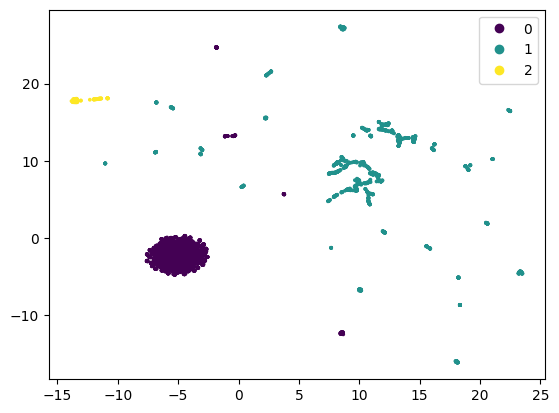

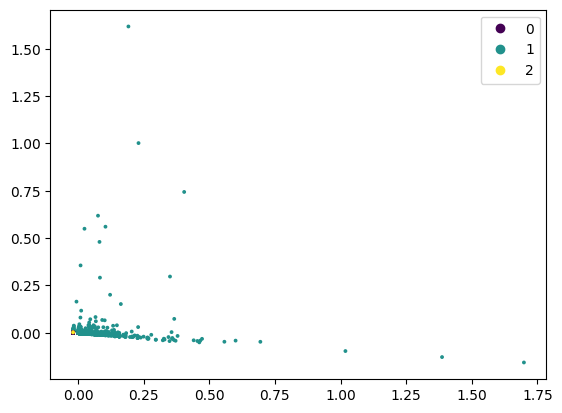

0: -------------------
stars                    7885.05190
betweenness_centrality      0.00000
out_degree                  0.05545
in_degree                   0.03449
page_rank_0.90              0.00016
page_rank_0.50              0.00018
hits                        0.00000
dtype: float64
1: -------------------
stars                    11068.16351
betweenness_centrality       0.00000
out_degree                   1.26422
in_degree                    1.42713
page_rank_0.90               0.00029
page_rank_0.50               0.00024
hits                         0.00059
dtype: float64
2: -------------------
stars                    8321.58095
betweenness_centrality      0.00000
out_degree                  1.00000
in_degree                   0.00000
page_rank_0.90              0.00016
page_rank_0.50              0.00018
hits                        0.00000
dtype: float64


In [52]:
labels = KMeans(
    n_clusters = 3,
    random_state = 42
).fit_predict(umap_reduced_X)

print(len(set(labels.tolist())))

scatter_umap = plt.scatter(umap_visualize_X[:, 0], umap_visualize_X[:, 1], c = labels, s = 3)
plt.legend(handles=scatter_umap.legend_elements()[0], labels=set(labels))
plt.show()
pca = PCA(n_components=2).fit_transform(X)
scatter_pca = plt.scatter(pca[:, 0], pca[:, 1], c = labels, s = 3)
plt.legend(handles=scatter_pca.legend_elements()[0], labels=set(labels))
plt.show()
pd.set_option('display.float_format', lambda x: '%.5f' % x)
for label in set(labels.tolist()):
    data = dataset.loc[np.argwhere(labels == label).reshape(-1), :].copy()
    print(f'{label}: -------------------')
    print(data[['stars', *column_base]].mean())

In [56]:
github_dataset['explosion/spaCy'].mentioned_repos

['explosion/projects']

In [57]:
column_base

['betweenness_centrality',
 'out_degree',
 'in_degree',
 'page_rank_0.90',
 'page_rank_0.50',
 'hits']